In [1]:
image_tif = "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/biodiversity_0026.tif"
mask_png  = "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/biodiversity_0026.png"


In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["CMU Serif", "Computer Modern Roman", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
})


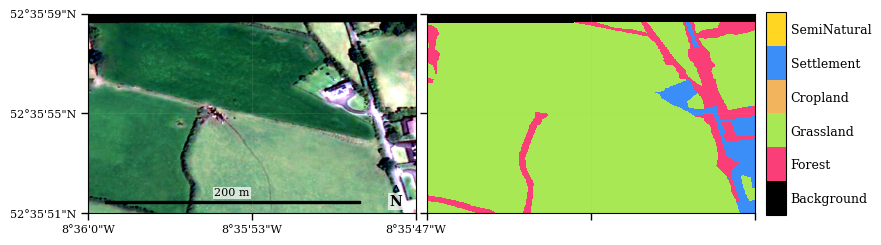

Saved: figure_rgb_mask_colorbar.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter, FixedLocator

# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "SemiNatural",
}

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def deg_to_dms(val, is_lon=True):
    hemi = ("W" if val < 0 else "E") if is_lon else ("S" if val < 0 else "N")
    v = abs(val)
    d = int(v)
    m = int((v - d) * 60)
    s = int(round((((v - d) * 60) - m) * 60))
    return f"{d}°{m:02d}'{s:d}\"{hemi}"

def three_ticks(vmin, vmax):
    return [vmin, (vmin + vmax) / 2, vmax]

def add_north_arrow(ax, extent):
    xmin, xmax, ymin, ymax = extent
    ax.annotate(
        "N",
        xy=(xmax - 0.06*(xmax-xmin), ymin + 0.16*(ymax-ymin)),
        xytext=(xmax - 0.06*(xmax-xmin), ymin + 0.06*(ymax-ymin)),
        arrowprops=dict(arrowstyle="-|>", linewidth=1),
        ha="center", va="center", fontsize=10, fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
    )

def add_scale_bar_latlon(ax, extent, length_m=200):
    xmin, xmax, ymin, ymax = extent
    lon0 = xmin + 0.05*(xmax-xmin)
    lat0 = ymin + 0.05*(ymax-ymin)
    meters_per_deg_lon = 111320 * np.cos(np.deg2rad(lat0))
    dlon = length_m / meters_per_deg_lon
    bar_h = 0.012*(ymax-ymin)

    ax.add_patch(plt.Rectangle((lon0, lat0), dlon, bar_h,
                               edgecolor="k", facecolor="k"))
    ax.text(
        lon0 + dlon/2, lat0 + 2.2*bar_h, f"{length_m} m",
        ha="center", va="bottom", fontsize=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
    )

def plot_rgb_mask_with_vertical_colorbar(image_tif, mask_png,
                                         out_png="figure_rgb_mask_colorbar.png"):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1,2,3]).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan
        b = src.bounds
        xmin, ymin, xmax, ymax = transform_bounds(
            src.crs, "EPSG:4326",
            b.left, b.bottom, b.right, b.top, densify_pts=21
        )
    extent = (xmin, xmax, ymin, ymax)

    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]

    rgb8 = rgb_percentile_uint8(rgb)

    # fixed classes 0..5 for consistent colorbar
    max_id = 5
    colors = np.zeros((max_id + 1, 3))
    for i in range(max_id + 1):
        colors[i] = np.array(COLOR_MAP.get(i, [180,180,180])) / 255
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_id + 1.5), cmap.N)

    # --- layout: 2 equal panels + separate colorbar axis ---
    fig = plt.figure(figsize=(9, 3.6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.06], wspace=0.05)

    ax0 = fig.add_subplot(gs[0, 0])  # RGB
    ax1 = fig.add_subplot(gs[0, 1])  # Mask
    cax = fig.add_subplot(gs[0, 2])  # Colorbar (does NOT shrink ax1)

    # --- make colorbar axis shorter (centered) ---
    sh = 0.73  # 80% height
    pos = cax.get_position()
    new_h = pos.height * sh
    new_y = pos.y0 + (pos.height - new_h) / 2
    cax.set_position([pos.x0, new_y, pos.width, new_h])
    

    # --- RGB panel (keep coords, north arrow, scale bar) ---
    ax0.imshow(rgb8, extent=extent, origin="upper")
    ax0.grid(True, linewidth=0.5, alpha=0.18)
    ax0.xaxis.set_major_locator(FixedLocator(three_ticks(xmin, xmax)))
    ax0.yaxis.set_major_locator(FixedLocator(three_ticks(ymin, ymax)))
    ax0.xaxis.set_major_formatter(FuncFormatter(lambda x, p: deg_to_dms(x, True)))
    ax0.yaxis.set_major_formatter(FuncFormatter(lambda y, p: deg_to_dms(y, False)))
    ax0.tick_params(direction="out", length=5, width=1, labelsize=8,
                    top=False, right=False, labeltop=False, labelright=False)
    ax0.set_title(""); ax0.set_xlabel(""); ax0.set_ylabel("")
    add_scale_bar_latlon(ax0, extent, length_m=200)
    add_north_arrow(ax0, extent)

    # --- Mask panel (NO coords/scale/north; keep ticks only) ---
    im = ax1.imshow(mask, cmap=cmap, norm=norm, extent=extent,
                    origin="upper", interpolation="nearest")
    ax1.grid(True, linewidth=0.5, alpha=0.18)
    ax1.xaxis.set_major_locator(FixedLocator(three_ticks(xmin, xmax)))
    ax1.yaxis.set_major_locator(FixedLocator(three_ticks(ymin, ymax)))
    ax1.tick_params(direction="out", length=5, width=1,
                    top=False, right=False, labeltop=False, labelright=False,
                    labelbottom=False, labelleft=False)
    ax1.set_title(""); ax1.set_xlabel(""); ax1.set_ylabel("")

    # --- Vertical colorbar (no tick marks, names only) ---
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.set_ticks(np.arange(0, 6))
    cbar.set_ticklabels([CLASS_NAMES[i] for i in range(0, 6)])
    cbar.ax.tick_params(which="both", length=0, width=0, labelsize=9)
    cbar.ax.minorticks_off()

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# Run
plot_rgb_mask_with_vertical_colorbar(image_tif, mask_png)


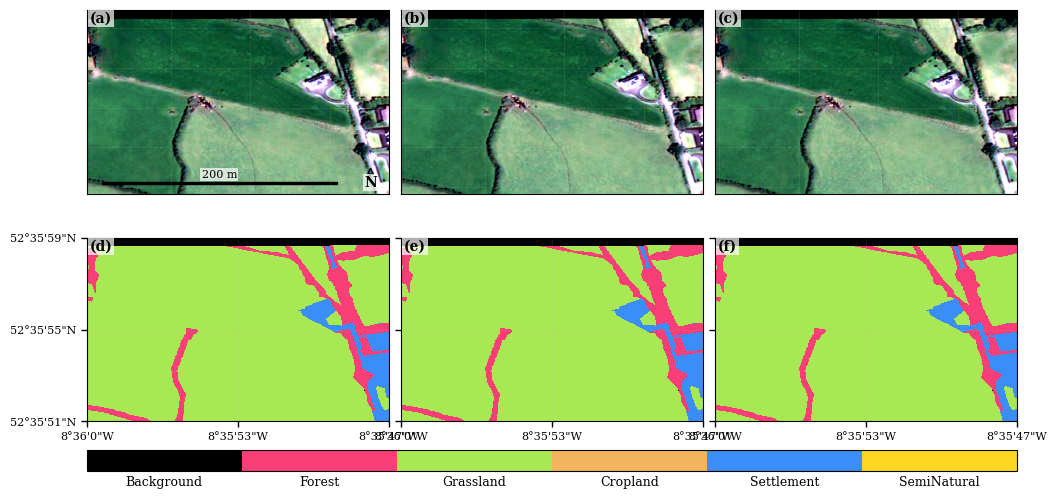

Saved: biodiversity_examples_3countries.png


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter, FixedLocator

# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "SemiNatural",
}

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def deg_to_dms(val, is_lon=True):
    hemi = ("W" if val < 0 else "E") if is_lon else ("S" if val < 0 else "N")
    v = abs(val)
    d = int(v)
    m = int((v - d) * 60)
    s = int(round((((v - d) * 60) - m) * 60))
    return f"{d}°{m:02d}'{s:d}\"{hemi}"

def three_ticks(vmin, vmax):
    return [vmin, (vmin + vmax) / 2, vmax]

def panel_label(ax, txt):
    ax.text(
        0.01, 0.99, txt,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10, fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.2)
    )

def add_north_arrow(ax, extent):
    xmin, xmax, ymin, ymax = extent
    ax.annotate(
        "N",
        xy=(xmax - 0.06*(xmax-xmin), ymin + 0.16*(ymax-ymin)),
        xytext=(xmax - 0.06*(xmax-xmin), ymin + 0.06*(ymax-ymin)),
        arrowprops=dict(arrowstyle="-|>", linewidth=1),
        ha="center", va="center", fontsize=10, fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
    )

def add_scale_bar_latlon(ax, extent, length_m=200):
    xmin, xmax, ymin, ymax = extent
    lon0 = xmin + 0.05*(xmax-xmin)
    lat0 = ymin + 0.05*(ymax-ymin)
    meters_per_deg_lon = 111320 * np.cos(np.deg2rad(lat0))
    dlon = length_m / meters_per_deg_lon
    bar_h = 0.012*(ymax-ymin)

    ax.add_patch(plt.Rectangle((lon0, lat0), dlon, bar_h,
                               edgecolor="k", facecolor="k"))
    ax.text(
        lon0 + dlon/2, lat0 + 2.2*bar_h, f"{length_m} m",
        ha="center", va="bottom", fontsize=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
    )

def read_rgb_and_extent_latlon(image_tif):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1,2,3]).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan
        b = src.bounds
        xmin, ymin, xmax, ymax = transform_bounds(
            src.crs, "EPSG:4326",
            b.left, b.bottom, b.right, b.top,
            densify_pts=21
        )
    extent = (xmin, xmax, ymin, ymax)
    rgb8 = rgb_percentile_uint8(rgb)
    return rgb8, extent

def read_mask(mask_png):
    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]
    return mask

def plot_examples_3countries(
    samples,
    out_png="biodiversity_examples_3countries.png",
    p_lo=2, p_hi=98, gamma=1.1,
    scale_m=200,
):
    # fixed classes 0..5 for consistent colorbar
    max_id = 5
    colors = np.zeros((max_id + 1, 3))
    for i in range(max_id + 1):
        colors[i] = np.array(COLOR_MAP.get(i, [180, 180, 180])) / 255.0
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_id + 1.5), cmap.N)

    # 3 rows: RGB, Mask, Colorbar
    fig = plt.figure(figsize=(12, 6.2))
    gs = fig.add_gridspec(
        3, 3,
        height_ratios=[1, 1, 0.10],
        hspace=0.08,
        wspace=0.04
    )

    # panel labels
    top_labels = ["(a)", "(b)", "(c)"]
    bot_labels = ["(d)", "(e)", "(f)"]

    # store one "im" for colorbar
    last_im = None

    for j, s in enumerate(samples):
        rgb8, extent = read_rgb_and_extent_latlon(s["image_tif"])
        mask = read_mask(s["mask_png"])

        # --- RGB row ---
        ax_rgb = fig.add_subplot(gs[0, j])
        ax_rgb.imshow(rgb8, extent=extent, origin="upper")
        ax_rgb.grid(True, linewidth=0.5, alpha=0.18)
        ax_rgb.set_title("")
        ax_rgb.set_xlabel("")
        ax_rgb.set_ylabel("")
        # keep it clean: no coordinate labels on the top row
        ax_rgb.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

        # add scale + north only once (leftmost) to avoid repetition clutter
        if j == 0:
            add_scale_bar_latlon(ax_rgb, extent, length_m=scale_m)
            add_north_arrow(ax_rgb, extent)

        panel_label(ax_rgb, top_labels[j])

        # --- Mask row ---
        ax_m = fig.add_subplot(gs[1, j])
        last_im = ax_m.imshow(mask, cmap=cmap, norm=norm, extent=extent,
                              origin="upper", interpolation="nearest")
        ax_m.grid(True, linewidth=0.5, alpha=0.18)
        ax_m.set_title("")
        ax_m.set_xlabel("")
        ax_m.set_ylabel("")

        # Minimal coords: only outer labels (bottom row + leftmost y) so it stays readable
        ax_m.xaxis.set_major_locator(FixedLocator(three_ticks(extent[0], extent[1])))
        ax_m.yaxis.set_major_locator(FixedLocator(three_ticks(extent[2], extent[3])))
        ax_m.xaxis.set_major_formatter(FuncFormatter(lambda x, p: deg_to_dms(x, True)))
        ax_m.yaxis.set_major_formatter(FuncFormatter(lambda y, p: deg_to_dms(y, False)))

        ax_m.tick_params(direction="out", length=4, width=1, labelsize=8,
                         top=False, right=False, labeltop=False, labelright=False)

        # hide inner y labels except first column
        if j != 0:
            ax_m.tick_params(labelleft=False)

        panel_label(ax_m, bot_labels[j])

    # --- Horizontal colorbar spanning the bottom ---
    cax = fig.add_subplot(gs[2, :])
    cbar = fig.colorbar(last_im, cax=cax, orientation="horizontal")

    # categorical labels centered on each class block
    cbar.set_ticks(np.arange(0, 6))
    cbar.set_ticklabels([CLASS_NAMES[i] for i in range(0, 6)])

    # make it look like a legend bar (no tick marks)
    cbar.ax.tick_params(which="both", length=0, width=0, labelsize=9)
    cbar.ax.minorticks_off()

    # move labels below the bar slightly (optional but nice)
    cbar.ax.xaxis.set_ticks_position('bottom')

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# ------------------------------------------------------------
# For now, reuse the same image/mask 3 times (easy to swap later)
# Just replace these paths for Denmark/Colombia when ready.
SAMPLES = [
    {"name": "Ireland",  "image_tif": image_tif, "mask_png": mask_png},
    {"name": "Denmark",  "image_tif": image_tif, "mask_png": mask_png},
    {"name": "Colombia", "image_tif": image_tif, "mask_png": mask_png},
]

plot_examples_3countries(SAMPLES, out_png="biodiversity_examples_3countries.png", scale_m=200)


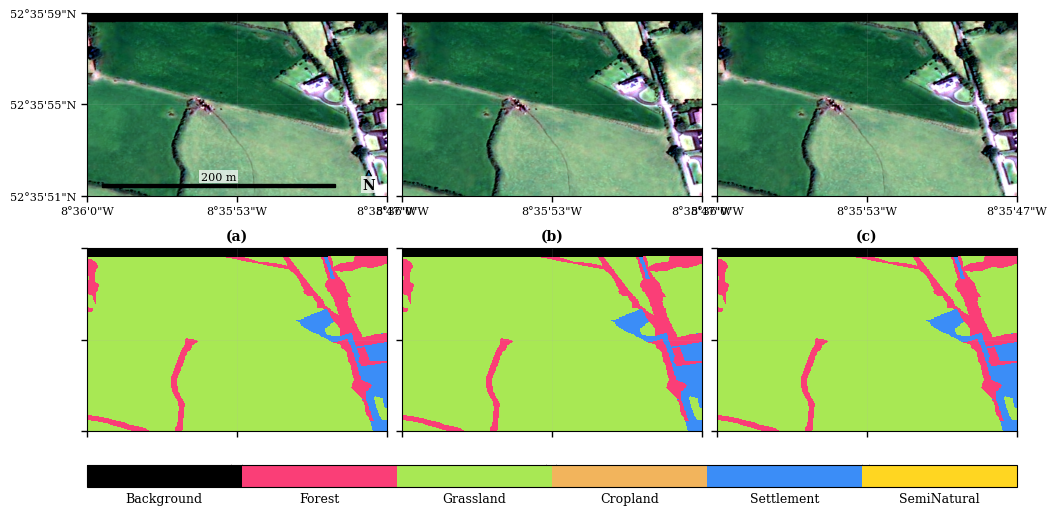

Saved: biodiversity_examples_3countries.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter, FixedLocator

# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "SemiNatural",
}

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def deg_to_dms(val, is_lon=True):
    hemi = ("W" if val < 0 else "E") if is_lon else ("S" if val < 0 else "N")
    v = abs(val)
    d = int(v)
    m = int((v - d) * 60)
    s = int(round((((v - d) * 60) - m) * 60))
    return f"{d}°{m:02d}'{s:d}\"{hemi}"

def three_ticks(vmin, vmax):
    return [vmin, (vmin + vmax) / 2, vmax]

def add_north_arrow(ax, extent):
    xmin, xmax, ymin, ymax = extent
    ax.annotate(
        "N",
        xy=(xmax - 0.06*(xmax-xmin), ymin + 0.16*(ymax-ymin)),
        xytext=(xmax - 0.06*(xmax-xmin), ymin + 0.06*(ymax-ymin)),
        arrowprops=dict(arrowstyle="-|>", linewidth=1),
        ha="center", va="center", fontsize=10, fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
    )

def add_scale_bar_latlon(ax, extent, length_m=200):
    xmin, xmax, ymin, ymax = extent
    lon0 = xmin + 0.05*(xmax-xmin)
    lat0 = ymin + 0.05*(ymax-ymin)
    meters_per_deg_lon = 111320 * np.cos(np.deg2rad(lat0))
    dlon = length_m / meters_per_deg_lon
    bar_h = 0.012*(ymax-ymin)

    ax.add_patch(plt.Rectangle((lon0, lat0), dlon, bar_h,
                               edgecolor="k", facecolor="k"))
    ax.text(
        lon0 + dlon/2, lat0 + 2.2*bar_h, f"{length_m} m",
        ha="center", va="bottom", fontsize=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1)
    )

def read_rgb_and_extent_latlon(image_tif):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1,2,3]).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan
        b = src.bounds
        xmin, ymin, xmax, ymax = transform_bounds(
            src.crs, "EPSG:4326",
            b.left, b.bottom, b.right, b.top,
            densify_pts=21
        )
    extent = (xmin, xmax, ymin, ymax)
    rgb8 = rgb_percentile_uint8(rgb)
    return rgb8, extent

def read_mask(mask_png):
    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]
    return mask

def centered_panel_label_below(ax, label, y=-0.16):
    # y is relative to axis; negative puts it below
    ax.text(
        0.5, y, label,
        transform=ax.transAxes,
        ha="center", va="top",
        fontsize=10, fontweight="bold"
    )

def plot_examples_3countries_layout(samples, out_png="biodiversity_examples_3countries.png", scale_m=200):
    # fixed classes 0..5 for consistent colorbar
    max_id = 5
    colors = np.zeros((max_id + 1, 3))
    for i in range(max_id + 1):
        colors[i] = np.array(COLOR_MAP.get(i, [180, 180, 180])) / 255.0
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_id + 1.5), cmap.N)

    # Grid:
    # Row 0: RGB images
    # Row 1: mask images
    # Row 2: horizontal colorbar (spans all columns)
    fig = plt.figure(figsize=(12, 6.4))
    gs = fig.add_gridspec(
        3, 3,
        height_ratios=[1, 1, 0.10],
        hspace=0.10,   # room for (a)(b)(c) and (d)(e)(f) under panels
        wspace=0.05
    )

    top_labels = ["(a)", "(b)", "(c)"]
    bot_labels = ["(d)", "(e)", "(f)"]

    last_im = None

    for j, s in enumerate(samples):
        rgb8, extent = read_rgb_and_extent_latlon(s["image_tif"])
        mask = read_mask(s["mask_png"])

        # --- RGB row: WITH coordinates (left+bottom only) ---
        ax_rgb = fig.add_subplot(gs[0, j])
        ax_rgb.imshow(rgb8, extent=extent, origin="upper")
        ax_rgb.grid(True, linewidth=0.5, alpha=0.18)

        ax_rgb.xaxis.set_major_locator(FixedLocator(three_ticks(extent[0], extent[1])))
        ax_rgb.yaxis.set_major_locator(FixedLocator(three_ticks(extent[2], extent[3])))
        ax_rgb.xaxis.set_major_formatter(FuncFormatter(lambda x, p: deg_to_dms(x, True)))
        ax_rgb.yaxis.set_major_formatter(FuncFormatter(lambda y, p: deg_to_dms(y, False)))

        # show coords on bottom; show y labels only on the left-most panel
        ax_rgb.tick_params(direction="out", length=4, width=1, labelsize=8,
                           top=False, right=False, labeltop=False, labelright=False)
        if j != 0:
            ax_rgb.tick_params(labelleft=False)

        ax_rgb.set_title(""); ax_rgb.set_xlabel(""); ax_rgb.set_ylabel("")

        # scale + north arrow only on (a) to avoid repetition clutter
        if j == 0:
            add_scale_bar_latlon(ax_rgb, extent, length_m=scale_m)
            add_north_arrow(ax_rgb, extent)

        centered_panel_label_below(ax_rgb, top_labels[j], y=-0.18)

        # --- Mask row: NO coordinates (and no tick labels) ---
        ax_m = fig.add_subplot(gs[1, j])
        last_im = ax_m.imshow(mask, cmap=cmap, norm=norm, extent=extent,
                              origin="upper", interpolation="nearest")
        ax_m.grid(True, linewidth=0.5, alpha=0.18)

        # keep tick marks if you want; but no labels (clean)
        ax_m.xaxis.set_major_locator(FixedLocator(three_ticks(extent[0], extent[1])))
        ax_m.yaxis.set_major_locator(FixedLocator(three_ticks(extent[2], extent[3])))
        ax_m.tick_params(direction="out", length=4, width=1,
                         top=False, right=False, labeltop=False, labelright=False,
                         labelbottom=False, labelleft=False)

        ax_m.set_title(""); ax_m.set_xlabel(""); ax_m.set_ylabel("")
        centered_panel_label_below(ax_m, bot_labels[j], y=-0.18)

    # --- Horizontal colorbar under masks, spanning all columns ---
    cax = fig.add_subplot(gs[2, :])
    cbar = fig.colorbar(last_im, cax=cax, orientation="horizontal")
    cbar.set_ticks(np.arange(0, 6))
    cbar.set_ticklabels([CLASS_NAMES[i] for i in range(0, 6)])
    cbar.ax.tick_params(which="both", length=0, width=0, labelsize=9)
    cbar.ax.minorticks_off()

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# ------------------------------------------------------------
# For now, reuse the same image/mask 3 times (swap later)
SAMPLES = [
    {"name": "Ireland",  "image_tif": image_tif, "mask_png": mask_png},
    {"name": "Denmark",  "image_tif": image_tif, "mask_png": mask_png},
    {"name": "Colombia", "image_tif": image_tif, "mask_png": mask_png},
]

plot_examples_3countries_layout(SAMPLES, out_png="biodiversity_examples_3countries.png", scale_m=200)


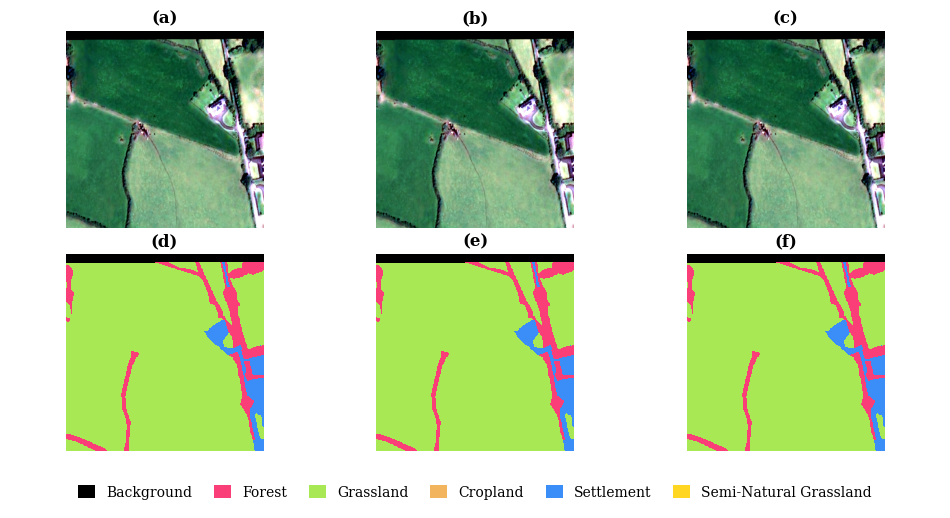

Saved: biodiversity_examples_clean.png


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Natural Grassland",
}

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def read_rgb(image_tif):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1,2,3]).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan
    return rgb_percentile_uint8(rgb)

def read_mask(mask_png):
    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]
    return mask

def add_panel_label_above(ax, label):
    ax.text(
        0.5, 1.02, label,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

def plot_examples_no_coords(samples, out_png="biodiversity_examples_clean.png"):
    # fixed classes 0..5
    max_id = 5
    colors = np.zeros((max_id + 1, 3))
    for i in range(max_id + 1):
        colors[i] = np.array(COLOR_MAP[i]) / 255.0
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_id + 1.5), cmap.N)

    # Grid: RGB row, mask row, legend row
    fig = plt.figure(figsize=(12, 6.2))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.16], hspace=0.18, wspace=0.005)

    top_labels = ["(a)", "(b)", "(c)"]
    bot_labels = ["(d)", "(e)", "(f)"]

    # --- Top row: RGB ---
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[0, j])
        rgb8 = read_rgb(s["image_tif"])
        ax.imshow(rgb8)
        ax.set_axis_off()            # removes ticks/coords/spines
        add_panel_label_above(ax, top_labels[j])

    # --- Bottom row: masks ---
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[1, j])
        mask = read_mask(s["mask_png"])
        ax.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
        ax.set_axis_off()
        add_panel_label_above(ax, bot_labels[j])

    # --- Discrete “box legend” across bottom (instead of a colorbar) ---
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis("off")

    handles = [
        Patch(facecolor=np.array(COLOR_MAP[i]) / 255.0, edgecolor="none", label=CLASS_NAMES[i])
        for i in range(0, 6)
    ]

    legend_ax.legend(
        handles=handles,
        loc="center",
        ncol=6,               # one row; change to 3 for 2 rows
        frameon=False,
        fontsize=10,
        handlelength=1.2,
        handleheight=1.0,
        columnspacing=1.6
    )

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# ------------------------------------------------------------
# For now, reuse the same image/mask 3 times (swap later)
SAMPLES = [
    {"name": "Ireland",  "image_tif": image_tif, "mask_png": mask_png},
    {"name": "Denmark",  "image_tif": image_tif, "mask_png": mask_png},
    {"name": "Colombia", "image_tif": image_tif, "mask_png": mask_png},
]

plot_examples_no_coords(SAMPLES, out_png="biodiversity_examples_clean.png")


In [7]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 10,          # base font size (MDPI body text)
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 10,
})


NameError: name 'read_rgb_and_mpp' is not defined

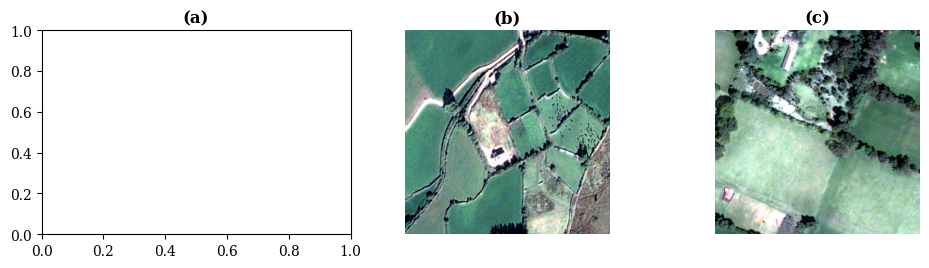

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Natural Grassland",
}

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def read_rgb(image_tif):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1,2,3]).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan
    return rgb_percentile_uint8(rgb)

def read_mask(mask_png):
    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]
    return mask

def add_panel_label_above(ax, label):
    ax.text(
        0.5, 1.02, label,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

def plot_examples_no_coords(samples, out_png="biodiversity_examples_clean.png"):
    # fixed classes 0..5
    max_id = 5
    colors = np.zeros((max_id + 1, 3))
    for i in range(max_id + 1):
        colors[i] = np.array(COLOR_MAP[i]) / 255.0
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_id + 1.5), cmap.N)

    # Grid: RGB row, mask row, legend row
    fig = plt.figure(figsize=(12, 6.2))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, -0.05], hspace=0.30, wspace=0.005)

    top_labels = ["(a)", "(b)", "(c)"]
    bot_labels = ["(d)", "(e)", "(f)"]

    # --- Top row: RGB ---
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[0, j])
        rgb8 = read_rgb(s["image_tif"])
        ax.imshow(rgb8)
        ax.set_axis_off()            # removes ticks/coords/spines
        add_panel_label_above(ax, top_labels[j])

    # --- Top row: RGB (ONLY (a): 50 m + North) ---
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[0, j])
        rgb8, mpp = read_rgb_and_mpp(s["image_tif"])
        ax.imshow(rgb8)
        ax.set_axis_off()
        add_panel_label_above(ax, top_labels[j])
    
        if j == 0:  # ONLY top-left
            add_scale_bar_pixels(ax, rgb8.shape, mpp, length_m=50)
            add_north_arrow_pixels(ax, rgb8.shape)


    # --- Discrete “box legend” across bottom (instead of a colorbar) ---
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis("off")

    handles = [
        Patch(facecolor=np.array(COLOR_MAP[i]) / 255.0, edgecolor="none", label=CLASS_NAMES[i])
        for i in range(0, 6)
    ]

    legend_ax.legend(
        handles=handles,
        loc="center",
        ncol=6,               # one row; change to 3 for 2 rows
        frameon=False,
        fontsize=10,
        handlelength=1.2,
        handleheight=1.0,
        columnspacing=1.6
    )

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# ------------------------------------------------------------
# For now, reuse the same image/mask 3 times (swap later)
SAMPLES = [
    {
        "name": "Denmark",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/den4_0004.tif",
        "mask_png":  "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/den4_0004.png",
    }, #den0_0014.tif
    {
        "name": "Ireland",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/ireland2_0022.tif",
        "mask_png":  "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/ireland2_0022.png",
    },
    {
        "name": "Colombia",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/col1_0020.tif",
        "mask_png":  "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/col1_0020.png",
    },
]


plot_examples_no_coords(SAMPLES, out_png="biodiversity_examples_clean.png")


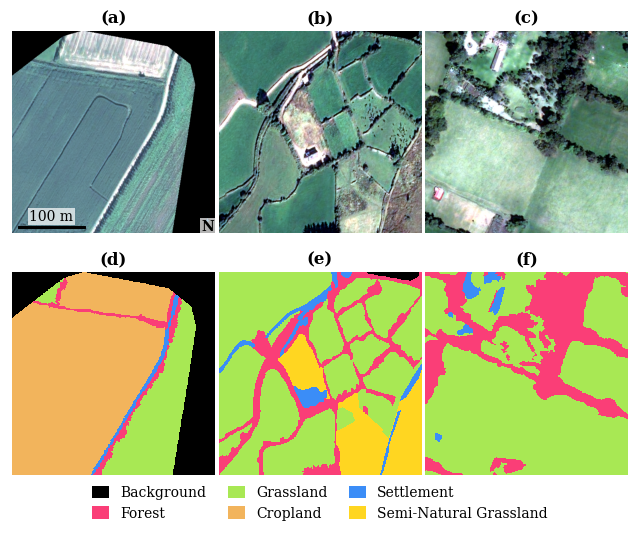

Saved: allcountries.png


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from PIL import Image
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle

# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Natural Grassland",
}

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def read_rgb_and_mpp(image_tif):
    """Return rgb8 and meters-per-pixel in x-direction (robust for projected or EPSG:4326)."""
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1,2,3]).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan

        # pixel size in CRS units
        px = abs(float(src.transform.a))

        if src.crs is not None and src.crs.is_projected:
            mpp_x = px  # already meters (or feet, but usually meters)
        else:
            # px is degrees/pixel -> convert degrees to meters using latitude
            # use the raster center latitude
            cy = (src.bounds.top + src.bounds.bottom) / 2.0
            # meters per degree longitude at latitude
            m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(cy))
            mpp_x = px * m_per_deg_lon

    return rgb_percentile_uint8(rgb), mpp_x


def read_mask(mask_png):
    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]
    return mask

def add_panel_label_above(ax, label):
    ax.text(
        0.5, 1.02, label,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

def add_scale_bar_pixels(ax, img_shape, meters_per_pixel, length_m=200,
                         pad_px=14, bar_height_px=6):
    h, w = img_shape[:2]
    if meters_per_pixel <= 0:
        return

    bar_len_px = int(round(length_m / meters_per_pixel))

    # only clamp the MAX so it doesn't run off the image
    bar_len_px = min(bar_len_px, w - 2*pad_px)

    # if it's too tiny to see, you can either skip or still draw it
    if bar_len_px < 3:
        return

    x0 = pad_px
    y0 = h - pad_px - bar_height_px

    ax.add_patch(Rectangle((x0, y0), bar_len_px, bar_height_px,
                           facecolor="black", edgecolor="black", linewidth=0.8))
    ax.text(
        x0 + bar_len_px/2, y0 - 5, f"{length_m} m",
        ha="center", va="bottom", fontsize=10,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0)
    )


def add_north_arrow_pixels(ax, img_shape, pad_px=18, size_px=36):
    """North arrow fully inside image bounds."""
    h, w = img_shape[:2]

    # pull inward a bit more than the scale bar
    x = w - pad_px - size_px * 0.02
    y = h - pad_px

    ax.annotate(
        "N",
        xy=(x, y - size_px),
        xytext=(x, y),
        ha="center", va="center",
        fontsize=10, fontweight="bold",
        arrowprops=dict(arrowstyle="-|>", linewidth=1.0),
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0)
    )

def plot_examples_no_coords(samples, out_png="biodiversity_examples_clean.png",
                            scale_m=200, add_north=True):
    # fixed classes 0..5
    max_id = 5
    colors = np.zeros((max_id + 1, 3))
    for i in range(max_id + 1):
        colors[i] = np.array(COLOR_MAP[i]) / 255.0
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_id + 1.5), cmap.N)

    # Grid: RGB row, mask row, legend row
    fig = plt.figure(figsize=(8, 6))

    # ✅ tighter columns: reduce wspace
    # ✅ legend row: use small positive height ratio (negative is invalid)
    gs = fig.add_gridspec(
        3, 3,
        height_ratios=[1, 1, -0.1],
        hspace=0.30,
        wspace=0.0
    )

    top_labels = ["(a)", "(b)", "(c)"]
    bot_labels = ["(d)", "(e)", "(f)"]

    # --- Top row: RGB (ONLY (a): 50 m + North) ---
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[0, j])
        rgb8, mpp = read_rgb_and_mpp(s["image_tif"])
        ax.imshow(rgb8)
        ax.set_axis_off()
        add_panel_label_above(ax, top_labels[j])
    
        if j == 0:  # ONLY top-left
            add_scale_bar_pixels(ax, rgb8.shape, mpp, length_m=100)
            add_north_arrow_pixels(ax, rgb8.shape)
    

    # --- Bottom row: masks ---
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[1, j])
        mask = read_mask(s["mask_png"])
        ax.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
        ax.set_axis_off()
        add_panel_label_above(ax, bot_labels[j])

    # --- Discrete “box legend” across bottom (2 rows) ---
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis("off")

    handles = [
        Patch(facecolor=np.array(COLOR_MAP[i]) / 255.0, edgecolor="none", label=CLASS_NAMES[i])
        for i in range(0, 6)
    ]

    legend_ax.legend(
        handles=handles,
        loc="center",
        ncol=3,               # ✅ 2 rows (3 columns each)
        frameon=False,
        fontsize=10,
        handlelength=1.2,
        handleheight=1.0,
        columnspacing=1.6
    )

    plt.savefig(out_png, dpi=300, pad_inches=0.02)
    plt.show()
    print("Saved:", out_png)

# ------------------------------------------------------------
SAMPLES = [
    {
        "name": "Denmark",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/den4_0004.tif",
        "mask_png":  "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/den4_0004.png",
    },
    {
        "name": "Ireland",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/ireland2_0022.tif",
        "mask_png":  "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/ireland2_0022.png",
    },
    {
        "name": "Colombia",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/images/col1_0020.tif",
        "mask_png":  "/home/lainey/Desktop/data/Biodiversity_tiff/Val/masks/col1_0020.png",
    },
]

plot_examples_no_coords(SAMPLES, out_png="allcountries.png", scale_m=200, add_north=True)


In [10]:
import zipfile, os

image_tif = "/home/lainey/Desktop/data/Biodiversity_tiff/Val/OEM1.tif"


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.patches import Rectangle

def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def read_rgb_and_mpp(image_tif, band_order=(1,2,3)):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read(list(band_order)).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan

        px = abs(float(src.transform.a))
        if src.crs is not None and src.crs.is_projected:
            mpp_x = px
        else:
            cy = (src.bounds.top + src.bounds.bottom) / 2.0
            m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(cy))
            mpp_x = px * m_per_deg_lon

    return rgb_percentile_uint8(rgb), mpp_x

def add_scale_bar_pixels(ax, img_shape, meters_per_pixel, length_m=100,
                         pad_px=18, bar_height_px=10,
                         text_size=14, line_w=1.2, label_pad=1.6):
    h, w = img_shape[:2]
    if meters_per_pixel <= 0:
        return
    bar_len_px = int(round(length_m / meters_per_pixel))
    bar_len_px = min(bar_len_px, w - 2*pad_px)
    if bar_len_px < 3:
        return

    x0 = pad_px
    y0 = h - pad_px - bar_height_px
    ax.add_patch(Rectangle((x0, y0), bar_len_px, bar_height_px,
                           facecolor="black", edgecolor="black", linewidth=line_w))
    ax.text(
        x0 + bar_len_px/2, y0 - 6, f"{length_m} m",
        ha="center", va="bottom", fontsize=text_size,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=label_pad)
    )


def add_north_arrow_pixels(ax, img_shape, pad_px=22, size_px=55,
                           text_size=14, arrow_lw=1.4, label_pad=1.6):
    h, w = img_shape[:2]
    x = w - pad_px - size_px * 0.4
    y = h - pad_px
    ax.annotate(
        "N", xy=(x, y - size_px), xytext=(x, y),
        ha="center", va="center", fontsize=text_size, fontweight="bold",
        arrowprops=dict(arrowstyle="-|>", linewidth=arrow_lw),
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=label_pad)
    )

def plot_single_rgb(image_tif, out_png="OEM_rgb.png", scale_m=100, band_order=(1,2,3)):
    rgb8, mpp = read_rgb_and_mpp(image_tif, band_order=band_order)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(rgb8)
    ax.set_axis_off()

    add_scale_bar_pixels(ax, rgb8.shape, mpp, length_m=scale_m)
    add_north_arrow_pixels(ax, rgb8.shape)

    plt.savefig(out_png, dpi=300, pad_inches=0.02)
    plt.show()
    print("Saved:", out_png)
    print


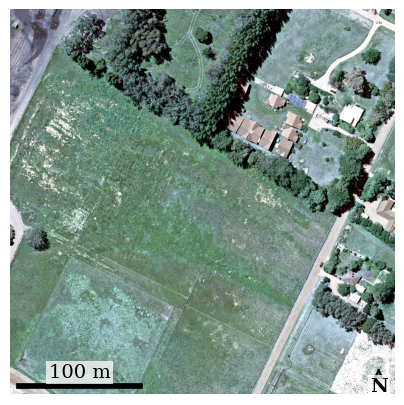

Saved: OEM_rgb_100m.png


In [12]:
plot_single_rgb(image_tif, out_png="OEM_rgb_100m.png", scale_m=100, band_order=(3,2,1))


In [13]:
def plot_three_rgb_row(samples, out_png="OEM_rgb_row.png",
                       scale_m=100, band_order=(1,2,3)):
    """
    samples = list of dicts with keys:
      - 'image_tif'
      - 'label' e.g. '(a)'
    """

    fig, axes = plt.subplots(
        nrows=1, ncols=3,
        figsize=(10, 5),
        constrained_layout=True
    )

    for ax, s in zip(axes, samples):
        rgb8, mpp = read_rgb_and_mpp(s["image_tif"], band_order=band_order)

        ax.imshow(rgb8)
        ax.set_axis_off()

        # panel label
        ax.text(
            0.5, 1.02, s["label"],
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=14, fontweight="bold"
        )

        # scale + north ONLY on the left-most panel
        if ax is axes[0]:
            add_scale_bar_pixels(ax, rgb8.shape, mpp, length_m=scale_m)
            add_north_arrow_pixels(ax, rgb8.shape)

    plt.savefig(out_png, dpi=300, pad_inches=0.02)
    plt.show()
    print("Saved:", out_png)


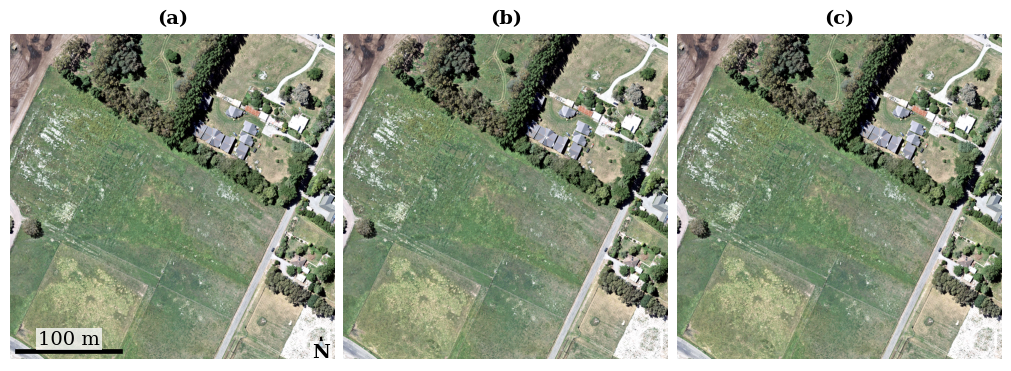

Saved: OEM_three_horizontal.png


In [14]:
SAMPLES = [
    {
        "label": "(a)",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/OEM1.tif",
    },
    {
        "label": "(b)",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/OEM1.tif",
    },
    {
        "label": "(c)",
        "image_tif": "/home/lainey/Desktop/data/Biodiversity_tiff/Val/OEM1.tif",
    },
]

plot_three_rgb_row(SAMPLES, out_png="OEM_three_horizontal.png", scale_m=100, band_order=(1,2,3))


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle

# ---------- your existing helpers (keep yours if already defined) ----------
def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)

def read_rgb_and_mpp(image_tif, band_order=(1,2,3)):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read(list(band_order)).astype(np.float32), (1,2,0))
        rgb[~np.isfinite(rgb)] = np.nan

        px = abs(float(src.transform.a))
        if src.crs is not None and src.crs.is_projected:
            mpp_x = px
        else:
            cy = (src.bounds.top + src.bounds.bottom) / 2.0
            m_per_deg_lon = 111320.0 * np.cos(np.deg2rad(cy))
            mpp_x = px * m_per_deg_lon

    return rgb_percentile_uint8(rgb), mpp_x

def add_scale_bar_pixels(ax, img_shape, meters_per_pixel, length_m=100,
                         pad_px=18, bar_height_px=10,
                         text_size=14, line_w=1.2, label_pad=1.6):
    h, w = img_shape[:2]
    if meters_per_pixel <= 0:
        return
    bar_len_px = int(round(length_m / meters_per_pixel))
    bar_len_px = min(bar_len_px, w - 2*pad_px)
    if bar_len_px < 3:
        return
    x0 = pad_px
    y0 = h - pad_px - bar_height_px
    ax.add_patch(Rectangle((x0, y0), bar_len_px, bar_height_px,
                           facecolor="black", edgecolor="black", linewidth=line_w))
    ax.text(x0 + bar_len_px/2, y0 - 6, f"{length_m} m",
            ha="center", va="bottom", fontsize=text_size,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=label_pad))

def add_north_arrow_pixels(ax, img_shape, pad_px=22, size_px=55,
                           text_size=14, arrow_lw=1.4, label_pad=1.6):
    h, w = img_shape[:2]
    x = w - pad_px - size_px * 0.4
    y = h - pad_px
    ax.annotate("N", xy=(x, y - size_px), xytext=(x, y),
                ha="center", va="center", fontsize=text_size, fontweight="bold",
                arrowprops=dict(arrowstyle="-|>", linewidth=arrow_lw),
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=label_pad))


# ---------- NEW: read OEM 8-class mask tif ----------
def read_mask_tif(mask_tif):
    with rasterio.open(mask_tif) as src:
        m = src.read(1)
    return m

# ---------- NEW: remap OEM 8 -> Biodiv 6 ----------
def remap_oem8_to_biodiv6(mask8, mapping, default=0):
    out = np.full(mask8.shape, default, dtype=np.uint8)
    for src_id, dst_id in mapping.items():
        out[mask8 == src_id] = dst_id
    return out


In [30]:
mask8 = read_mask_tif("/home/lainey/Desktop/data/Biodiversity_tiff/Val/christchurch_13_mask.tif")
print("Unique OEM IDs:", np.unique(mask8))

Unique OEM IDs: [2 3 4 5 8]


In [40]:
# OEM 8-class → Biodiversity 6-class mapping
# Biodiversity IDs:
# 0 Background, 1 Forest, 2 Grassland, 3 Cropland, 4 Settlement, 5 Semi-Natural Grassland

OEM8_TO_BIODIV6 = {
    1: 0,  # Bareland -> Background
    2: 2,  # Rangeland -> Grassland
    3: 4,  # Developed space -> Settlement
    4: 4,  # Road -> Settlement
    5: 1,  # Tree -> Forest
    6: 0,  # Water -> Background
    7: 3,  # Agriculture land -> Cropland
    8: 4,  # Building -> Settlement
}


In [41]:
import numpy as np

def remap_oem8_to_biodiv6(mask8, mapping, default=0):
    mask6 = np.full_like(mask8, default, dtype=np.uint8)
    for k, v in mapping.items():
        mask6[mask8 == k] = v
    return mask6


In [42]:
mask6 = remap_oem8_to_biodiv6(mask8, OEM8_TO_BIODIV6, default=0)
print("Unique mapped 6-class IDs:", np.unique(mask6))


Unique mapped 6-class IDs: [1 2 4]


In [43]:
COLOR_MAP = {
    0: [0, 0, 0],          # Background
    1: [250, 62, 119],     # Forest
    2: [168, 232, 84],     # Grassland
    3: [242, 180, 92],     # Cropland
    4: [59, 141, 247],     # Settlement
    5: [255, 214, 33],     # Semi-Natural Grassland
}


In [56]:
def plot_oem_rgb_mask_mapped(rgb_tif, mask8_tif, mapping,
                            out_png="OEM_three_horizontal.png",
                            scale_m=100, band_order=(1,2,3)):

    rgb8, mpp = read_rgb_and_mpp(rgb_tif, band_order=band_order)
    mask8 = read_mask_tif(mask8_tif)
    mask6 = remap_oem8_to_biodiv6(mask8, mapping, default=0)

    # simple discrete colormaps (no legend yet)
    oem_ids = np.arange(mask8.max() + 1)
    cmap8 = plt.get_cmap("tab10", len(oem_ids))
    norm8 = BoundaryNorm(np.arange(-0.5, len(oem_ids) + 0.5), cmap8.N)

    biodiv_colors = np.array([
        [0,   0,   0],     # 0 Background
        [250, 62,  119],   # 1 Forest
        [168, 232, 84],    # 2 Grassland
        [242, 180, 92],    # 3 Cropland
        [59,  141, 247],   # 4 Settlement
        [255, 214, 33],    # 5 Semi-Natural Grassland
    ]) / 255.0
    cmap6 = ListedColormap(biodiv_colors)
    norm6 = BoundaryNorm(np.arange(-0.5, 6.5), cmap6.N)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

    # (a) RGB
    axes[0].imshow(rgb8)
    axes[0].set_axis_off()
    axes[0].text(0.5, 1.02, "(a)", transform=axes[0].transAxes,
                 ha="center", va="bottom", fontsize=14, fontweight="bold")
    add_scale_bar_pixels(axes[0], rgb8.shape, mpp, length_m=scale_m)
    add_north_arrow_pixels(axes[0], rgb8.shape)

    # (b) OEM 8-class mask
    axes[1].imshow(mask8, cmap=cmap8, norm=norm8, interpolation="nearest")
    axes[1].set_axis_off()
    axes[1].text(0.5, 1.02, "(b)", transform=axes[1].transAxes,
                 ha="center", va="bottom", fontsize=14, fontweight="bold")

    # (c) mapped 6-class mask
    axes[2].imshow(mask6, cmap=cmap6, norm=norm6, interpolation="nearest")
    axes[2].set_axis_off()
    axes[2].text(0.5, 1.02, "(c)", transform=axes[2].transAxes,
                 ha="center", va="bottom", fontsize=14, fontweight="bold")


    from matplotlib.patches import Patch
    # classes to plot (exclude background)
    plot_class_ids = [k for k in CLASS_NAMES.keys() if k != 0]


    # --- legend handles (exclude background like the plots) ---
    handles = [
        Patch(facecolor=np.array(COLOR_MAP[k]) / 255.0, edgecolor="none", label=CLASS_NAMES[k])
        for k in plot_class_ids
    ]
    
    # Make a bit of room at the bottom for the legend
    fig.subplots_adjust(bottom=0.28)
    
    # Put legend under panel (b) by anchoring to axes[1]
    # (x=0.5 means centered under that axis; y is below it)
    axes[1].legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.30),
        ncol=3,              # 2 rows for 5 classes
        frameon=False,
        fontsize=10,
        handlelength=1.2,
        handleheight=1.0,
        columnspacing=1.6
    )


    plt.savefig(out_png, dpi=300, pad_inches=0.02)
    plt.show()
    print("Saved:", out_png)
    print("Unique OEM IDs:", np.unique(mask8))
    print("Unique mapped 6 IDs:", np.unique(mask6))


/tmp/ipykernel_57755/2546409818.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28)


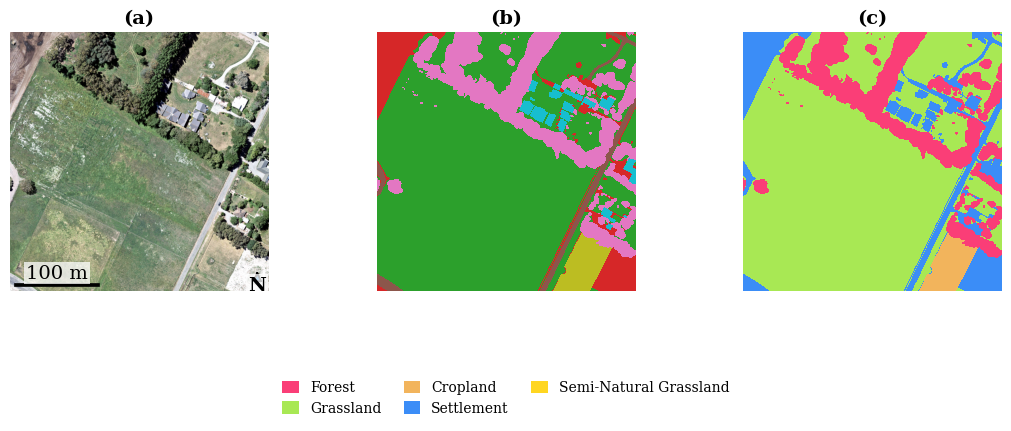

Saved: OEM_three_horizontal.png
Unique OEM IDs: [2 3 4 5 7 8]
Unique mapped 6 IDs: [1 2 3 4]


In [57]:
plot_oem_rgb_mask_mapped(
    rgb_tif="/home/lainey/Desktop/data/Biodiversity_tiff/Val/christchurch_36.tif",
    mask8_tif="/home/lainey/Desktop/data/Biodiversity_tiff/Val/christchurch_36_mask.tif",
    mapping=OEM8_TO_BIODIV6,
    out_png="OEM_three_horizontal.png",
    scale_m=100
)


## final attempt

In [65]:
CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Nat. Grassland",
}


In [69]:
# --- OEM 8-class legend info (from OEM website) ---
OEM8_HEX = {
    1: "#800000",  # Bareland
    2: "#00FF24",  # Rangeland
    3: "#949494",  # Developed space
    4: "#FFFFFF",  # Road
    5: "#226126",  # Tree
    6: "#0045FF",  # Water
    7: "#4BB549",  # Agriculture land
    8: "#DE1F07",  # Building
}
OEM8_NAMES = {
    1: "Bareland",
    2: "Rangeland",
    3: "Developed space",
    4: "Road",
    5: "Tree",
    6: "Water",
    7: "Agri. land",
    8: "Building",
}


In [84]:

def plot_oem_rgb_mask_mapped(rgb_tif, mask8_tif, mapping,
                            out_png="OEM_three_horizontal.png",
                            scale_m=100, band_order=(1,2,3)):

    rgb8, mpp = read_rgb_and_mpp(rgb_tif, band_order=band_order)
    mask8 = read_mask_tif(mask8_tif)
    mask6 = remap_oem8_to_biodiv6(mask8, mapping, default=0)

    # --- OEM 8-class colormap (use OEM HEX colors, fixed order 1..8) ---
    from matplotlib.colors import ListedColormap, BoundaryNorm, to_rgb
    oem_colors = [to_rgb(OEM8_HEX[i]) for i in range(1, 9)]
    cmap8 = ListedColormap(oem_colors)
    norm8 = BoundaryNorm(np.arange(0.5, 9.5, 1), cmap8.N)  # bins centered on 1..8

    # --- Biodiversity 6-class colormap (your fixed palette) ---
    biodiv_colors = np.array([
        [0,   0,   0],     # 0 Background
        [250, 62,  119],   # 1 Forest
        [168, 232, 84],    # 2 Grassland
        [242, 180, 92],    # 3 Cropland
        [59,  141, 247],   # 4 Settlement
        [255, 214, 33],    # 5 Semi-Natural Grassland
    ]) / 255.0
    cmap6 = ListedColormap(biodiv_colors)
    norm6 = BoundaryNorm(np.arange(-0.5, 6.5), cmap6.N)

    # --- layout ---
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=False)
    fig.subplots_adjust(bottom=0.36, wspace=0.02)  # space for two legends

    # (a) RGB
    axes[0].imshow(rgb8)
    axes[0].set_axis_off()
    axes[0].text(0.5, 1.02, "(a)", transform=axes[0].transAxes,
                 ha="center", va="bottom", fontsize=14, fontweight="bold")
    add_scale_bar_pixels(axes[0], rgb8.shape, mpp, length_m=scale_m)
    add_north_arrow_pixels(axes[0], rgb8.shape)

    # (b) OEM 8-class mask
    axes[1].imshow(mask8, cmap=cmap8, norm=norm8, interpolation="nearest")
    axes[1].set_axis_off()
    axes[1].text(0.5, 1.02, "(b)", transform=axes[1].transAxes,
                 ha="center", va="bottom", fontsize=14, fontweight="bold")

    # (c) mapped 6-class mask
    axes[2].imshow(mask6, cmap=cmap6, norm=norm6, interpolation="nearest")
    axes[2].set_axis_off()
    axes[2].text(0.5, 1.02, "(c)", transform=axes[2].transAxes,
                 ha="center", va="bottom", fontsize=14, fontweight="bold")

    # --- legends under (b) and (c) ---
    from matplotlib.patches import Patch

    # OEM legend (8 classes) under (b) -> 4 rows (ncol=2)
    oem_handles = [
        Patch(facecolor=to_rgb(OEM8_HEX[i]),
              edgecolor="black" if i == 4 else "none",  # road is white: outline it
              label=OEM8_NAMES[i])
        for i in range(1, 9)
    ]
    axes[1].legend(
        handles=oem_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        ncol=2,              # 8 items -> 4 rows
        frameon=False,
        fontsize=9,
        handlelength=1.2,
        handleheight=1.0,
        columnspacing=1.2,
        labelspacing=0.6,
    )

    # Biodiversity legend (exclude background) under (c) -> 3 rows (ncol=2)
    plot_class_ids = [k for k in CLASS_NAMES.keys() if k != 0]
    biodiv_handles = [
        Patch(facecolor=np.array(COLOR_MAP[k]) / 255.0, edgecolor="none", label=CLASS_NAMES[k])
        for k in plot_class_ids
    ]
    axes[2].legend(
        handles=biodiv_handles,
        loc="upper center",
        bbox_to_anchor=(0.6, 0),
        ncol=1,              # 5 items -> 3 rows
        frameon=False,
        fontsize=9,
        handlelength=1.2,
        handleheight=1.0,
        columnspacing=1.2,
        labelspacing=0.6,
    )

    plt.savefig(out_png, dpi=300, pad_inches=0.02)
    plt.show()

    print("Saved:", out_png)
    print("Unique OEM IDs:", np.unique(mask8))
    print("Unique mapped 6 IDs:", np.unique(mask6))


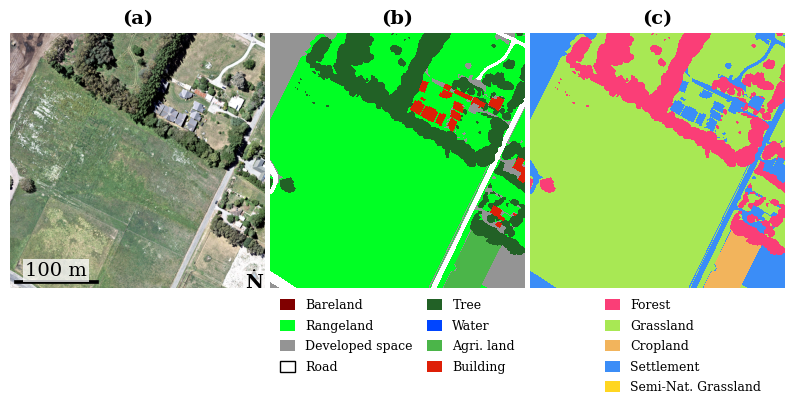

Saved: OEM_three_horizontal.png
Unique OEM IDs: [2 3 4 5 7 8]
Unique mapped 6 IDs: [1 2 3 4]


In [85]:
plot_oem_rgb_mask_mapped(
    rgb_tif="/home/lainey/Desktop/data/Biodiversity_tiff/Val/christchurch_36.tif",
    mask8_tif="/home/lainey/Desktop/data/Biodiversity_tiff/Val/christchurch_36_mask.tif",
    mapping=OEM8_TO_BIODIV6,
    out_png="OEM_three_horizontal.png",
    scale_m=100
)


## PLaceholders

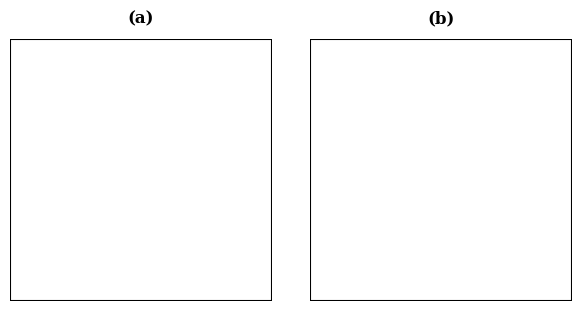

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(6, 3),
    constrained_layout=True
)

labels = ["(a)", "(b)"]

for ax, lab in zip(axes, labels):
    # draw empty square
    ax.add_patch(
        Rectangle((0, 0), 1, 1, fill=False, linewidth=1.5)
    )

    # panel label above
    ax.text(
        0.5, 1.05, lab,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.axis("off")

plt.savefig("placeholder_ab.png", dpi=300, pad_inches=0.02)
plt.show()


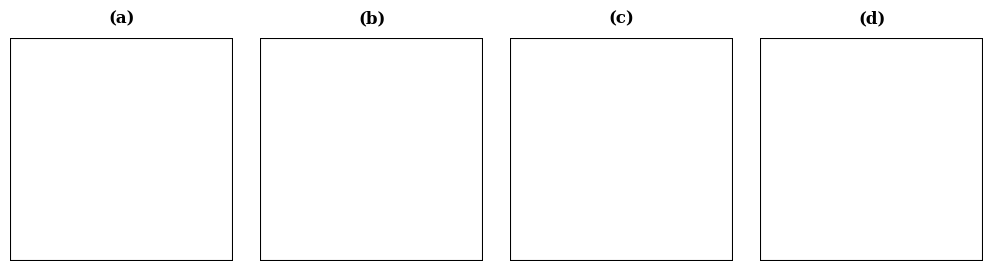

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(
    nrows=1, ncols=4,
    figsize=(10, 2.6),
    constrained_layout=True
)

labels = ["(a)", "(b)", "(c)", "(d)"]

for ax, lab in zip(axes, labels):
    # square placeholder
    ax.add_patch(
        Rectangle((0, 0), 1, 1, fill=False, linewidth=1.5)
    )

    # panel label above
    ax.text(
        0.5, 1.05, lab,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=12, fontweight="bold"
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.axis("off")

plt.savefig("placeholder_abcd_row.png", dpi=300, pad_inches=0.02)
plt.show()
